# Panorama Auto-Stitching

Author: Emily Cheng-hsin Wuu

**Maximum possible score = 100 points**

### Assignment Overview
In this assignment, you will implement an image stitching tool based on feature matching and homography, where the feature matching algorithm will be a provided as a BRIEF feature descriptor. Although we will not go into the details of the implementation of BRIEF, but you are encouraged to learn more about it from <a href="https://www.cs.ubc.ca/~lowe/525/papers/calonder_eccv10.pdf"> here</a>. 

The BRIEF feature descriptor is relatively small, fast, efficient, powerful, and simple to implement. This means that the BRIEF feature descriptor rivals more complex descriptors like SIFT while allowing for real-time computation. 

In this assignment, you'll then examine planar homographies between images because this is a common task in many real-world problems where surfaces like floors, tables, walls, roads, and other flat planes are encountered. The planar homography is defined by a 3x3 transformation matrix and it is used to compute the view of a given scene from a second camera location.

At the end of this assigment, you will be able to auto-stitch a panoramoa images from 2 separate images, and will also be able to create your own augumented reality photos. 

### Learning Objectives 
* Apply 2D planar and linear transformations and perform automatic image warping and basic augmented reality.

### Source

This assignment was derived, in part, from assignments used in conjunction with computer vision courses at Carnegie Mellon University: 

* 16-385 Computer Vision: Digit Recognition with Convolutional Neural Networks
    * Authors: *Abhinav Garlapati and Prakruti Gogia*
* 16-720A Computer Vision: Optical Character Recognition using Neural Networks
    * Authors: *Chen-Hsuan Lin, Brian Okorn, Yifan Xing, Sree Harsha Kalli, Siddarth Malreddy, Prakhar Pradeep Naval, Khushi Gupta, Shangxuan Wu, Bala Siva Jujjavarapu, Jingyan Wang, Yashasvi Agrawal*
* 16720-A S18 OCR using Neural Networks
    * Authors: *Leonid Keselman, Mohit Sharma, Arjun Sharma, Rawal Khirodkar, Aashi Manglik, Tanya Marwah*
* 16720-A F18 Neural Networks for Recognition
    * Authors: *Leonid Keselman, Tanya Marwah, Shashank Tripathi, Vibha Nasery, Jiayuan Li*
* 16720-B F18 Neural Networks for Recognition
    * Authors: *Gaurav Mittal, Akshita Mittel, Sowmya Munukutla, Nathaniel Chodosh, Ming-Fang Chang, Chengqian Che*

# Table of Contents 

#### [Part I: Planar Homography [75 pts]](#part-1)
- [Item 1 [0 pts]: BRIEF Descriptor](#q1)
- [Item 2 [25 pts]: Compute Homography](#q2)
- [Item 3 [25 pts]: RANSAC](#q3)
- [Item 4 [25 pts]: Automated Homography Estimation and Warping)](#q4)

#### [Part 2: Panoramas Stiching [25 pts]](#part-2)
- [Item 5 [15 pts]: Image Stitching](#q5)
- [Item 6 [10 pts]: Generate Panoramas](#q6)

In [1]:
#import Python libraries for this assignment
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import skimage.io
from scipy.spatial.distance import cdist
import math

<a name="part-1"></a>
# Part I: Planar Homography [ 75 pts]
In this section, we will implement a function to compute the planar homography that can describe the relationship between any 3D point to the 2D image planes. Suppose we have two cameras looking at a common plane in 3D space. Any 3D point $P$ on this plane will have a projected 2D point located at $u' = [u_1, v_1, 1]^T$ on the plane from the first camera and $x' = [x_1, y_1, 1]^T$ on the plane from the second camera. We can use a 3x3 matrix $H$ to define the relationship between $x'$ and $u'$, which is:
<center>$\lambda x' = H u'$ </center>
where $\lambda$ is a scalar. We call this relationship a planar homography. 
Now, we will be able to find $H$ between two 2D image planes by a set of N 2D correspondance points, which can be found by the BRIEF descriptor. Suppose that we have a set of N 2D coordinate ${x_1, x_2, .... , x_n}$ taken at the first camera view and ${u_1, u_2, .... , u_n}$ taken at the second camera view. We can derive a set of 2N independent linear equations in the form of $Ah = 0$, where $h$ is a vector of the elements of $H$ and $A$ is a matrix composed of elements derived from the points $u_i = [u_i, v_i, 1]^T$ and $x_i = [x_i, y_i, 1]^T$. 

Since for any set of homogeneous coordinates, we can get the following relation: 
<center>
$\lambda  \begin{bmatrix}
x_1\\
y_1\\
1
\end{bmatrix}  = \begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33} 
\end{bmatrix}  \begin{bmatrix}
u_1\\
v_1\\
1\end{bmatrix}$</center> 

We can expand the equation as the following:
<center>$\lambda x_1 = h_{11}u_1 + h_{12}v_1 + h_{13}$</center>
<center>$\lambda y_1 = h_{21}u_1 + h_{22}v_1 + h_{23}$</center>
<center>$\lambda = h_{31}u_1 + h_{32}v_1 + h_{33}$</center>

Then, we can obtain $x_1$ and $y_1$ as:
<center>$\Large x_1 = \frac{h_{11}u_1 + h_{12}v_1 + h_{13}}{h_{31}u_1 + h_{32}v_1 + h_{33}}$</center>
and
<center>$\Large y_1 = \frac{h_{21}u_1 + h_{22}v_1 + h_{23}}{h_{31}u_1 + h_{32}v_1 + h_{33}}$</center>

We can therefore use these formulas and rewrite the matrix $A$ and $h$ as:
<center>$A = \begin{bmatrix}
-u_1 & -v_1 & 1 & 0 & 0 & 0 & u_1x_1 & v_1x_1 & x_1  \\
0 & 0 & 0 & -u_2 & -v_2 & -1 & u_1y_1 & v_1y_1 & y_1 \\
\end{bmatrix}$</center>

and 

<center>$h = \begin{bmatrix}
h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33}  \\
\end{bmatrix}^T$</center>
<center></center>

For the rest of the $N - 1$ points, we can stack it to form matrix $A$ (size:$2N*9)$, and solve $h$ by the least square solution. 

Now that we have derived how to find $H$ mathematically, we will now implement the function that takes the correspondances between two images to compute the homography. Let's first see how can we find the correspondances between two images using the BRIEF descriptor.

<a name="q1"></a>
## BRIEF Descriptor [ 0 pts]
A descriptor can match the most informative features (called interest points) in one image and match them to corresponding interest points in a second image. The Binary Robust Independent Elementary Features (BRIEF) descriptor encodes information from a 9x9 patch $p$ centered around an interest point at the <b>pre-defined</b> scale of the interest point. It converts each 9x9 patch into a binary feature vector to represent an object. 

To do so, each interest point is first described by a feature vector which is a 128- to 512-bit string. Since BRIEF deals with the image at the pixel level, we need to smooth the patch in advance to decrease the degree of noise-sensitivity BRIEF brings. Typically, BRIEF uses Gaussian kernel to smooth the image. To get a binary feature vector out of the patch, we will create a binary feature of the binary test $(\tau)$, which, for each patch $p$, $(\tau)$ is defined as 
<center>$\large \tau(p; x,y) = 1 \space if p(x) < p(y), 0 \space otherwise$</center>
where $p(x)$ is the intensity value at pixel $x$.

We can choose a set of location pairs $n(x, y)$ to define a set of binary tests, where $n$ can be 128, 256 and 512. There are many statistics-based methods for selecting $(x, y)$ pairs, and $n$. For the following questions, we will assume $n=256$. Overall, BRIEF only uses a small number of Difference-of-Intensity patches to do feature matching, which is much faster than many of the traditional feature descriptors such as SIFT. 

After learning the theory part, let's look into how BRIEF is implemented. 


### Import Source Images

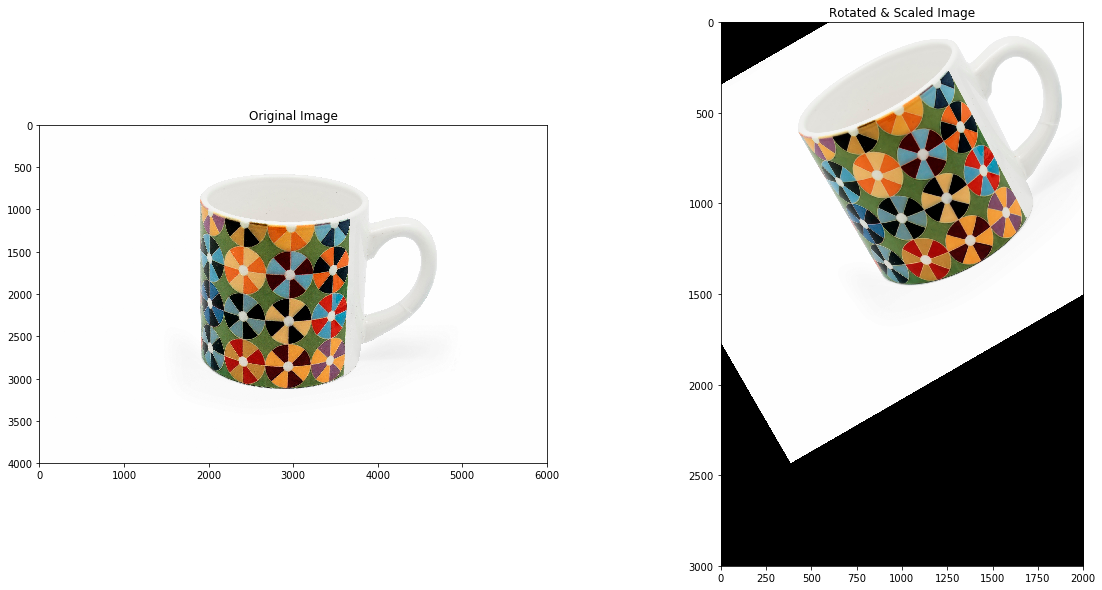

In [2]:
# load the image
demo_img = cv2.imread('img/mug.jpg')
#convert the color order to RGB
demo_img = cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB)
#create another image copy; convert RGB to greyscale
demo_img_gray = cv2.cvtColor(demo_img, cv2.COLOR_RGB2GRAY)

# create test image (add rotation and scaling from the demo_img)
#test_demo_img =  cv2.pyrDown(demo_img)
test_demo_img =  cv2.pyrDown(demo_img)
h, w, _ = test_demo_img.shape
rotation_matrix = cv2.getRotationMatrix2D((h // 2, w // 2), 30, 1)
test_demo_img = cv2.warpAffine(test_demo_img, rotation_matrix, (h, w))

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Original Image")
plots[0].imshow(demo_img)

plots[1].set_title("Rotated & Scaled Image")
plots[1].imshow(test_demo_img)

### Interest Point Detection with Feature Descriptor

In [3]:
def briefLite(img1, img2, visual=False):
    
    # convert image into gray scale (keep intensity only)
    demo_img_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    test_demo_img_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # Feature Descriptor
    FAST = cv2.FastFeatureDetector_create() 
    BRIEF = cv2.ORB_create()

    demo_ip = FAST.detect(img1, None)
    test_demo_ip = FAST.detect(img2, None)

    demo_ip, demo_descriptor = BRIEF.compute(demo_img_gray, demo_ip)
    test_demo_ip, test_demo_descriptor = BRIEF.compute(test_demo_img_gray, test_demo_ip)
    print("Number of Interest Points Detected in Original Image: ", len(demo_ip))
    print("Number of Interest Points Detected in Transformed Image: ", len(test_demo_ip))
    if visual:
        # visualize 
        visual_img = img1.copy()
        test_visual_img = img2.copy()
        cv2.drawKeypoints(visual_img, demo_ip, visual_img, color = (255, 0, 0))

        # Display image with and without keypoints size

        fx, plots = plt.subplots(1, 1, figsize=(20,10))

        _ = plots.set_title("Interest Points Detected in Original Image")
        _ = plots.imshow(visual_img, cmap='gray')

    return [demo_ip, test_demo_ip], [demo_descriptor, test_demo_descriptor]

Number of Interest Points Detected in Original Image:  45879
Number of Interest Points Detected in Transformed Image:  1982


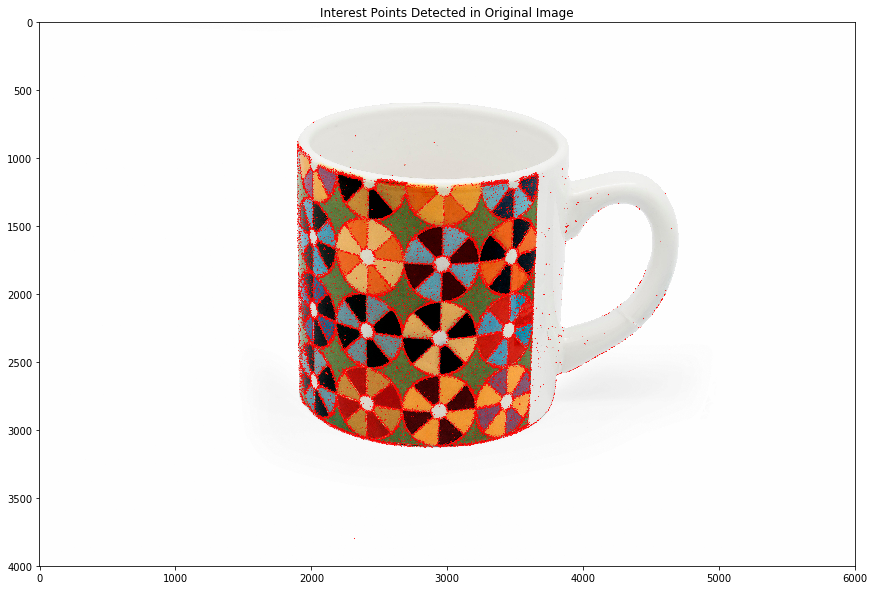

In [4]:
#look at the result to see many small points marked in the image
ip, descriptors = briefLite(demo_img, test_demo_img, visual=True)

### Descriptor Match

Many factors such as lighting and viewpoint affect the ability of BRIEF, and other methods, to reliably detect corresponding features in image pairs. A good descriptor will perform reliably and this performance can be measured as the distance between two descriptors. A smaller distance between two descriptors signifies comparable performance. The BRIEF descriptor relies on the Hamming distance which is the count of positions where two bit values differ. For example, 1111 and 0000 differ in all four positions while 1100 and 1101 differ only in one position. A common distance metric used to compare other descriptors is the $L^2$ norm. 

In [5]:
def briefMatch(desc1, desc2, ratio=0.8):
    '''
    performs the descriptor matching
    
    :param desc1, desc2: m1 x n and m2 x n matrix. m1 and m2 are the number of keypoints in image 1 and 2.
                                n is the number of bits in the brief
    :return matches: p x 2 matrix. where the first column are indices
                                        into desc1 and the second column are indices into desc2
    '''
    
    D = cdist(np.float32(desc1), np.float32(desc2), metric='hamming')
    # find shortested distance
    ix2 = np.argmin(D, axis=1)
    d1 = D.min(1)
    
    # find second smallest distance
    d12 = np.partition(D, 2, axis=1)[:,0:2]
    d2 = d12.max(1)
    r = d1 / (d2 + 1e-10)
    is_discr = r < ratio
    ix2 = ix2[is_discr]
    ix1 = np.arange(D.shape[0])[is_discr]
    matches = np.stack((ix1,ix2), axis=-1)
    return matches

def plotMatches(im1, im2, matches, locs1, locs2):
    n_locs1, n_locs2 = [], []
    # convert locs to NumPy array
    for i in locs1:
        n_locs1.append([i.pt[0], i.pt[1]])
    for i in locs2:
        n_locs2.append([i.pt[0], i.pt[1]])
    locs1 = np.array(n_locs1)
    locs2 = np.array(n_locs2)
    
    fig = plt.figure()
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]))
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im[0:im1.shape[0], 0:im1.shape[1]] = im1
    im[0:im2.shape[0], im1.shape[1]:] = im2
    plt.imshow(im, cmap='gray')
    for i in range(matches.shape[0]):
        pt1 = locs1[matches[i,0], 0:2]
        pt2 = locs2[matches[i,1], 0:2].copy()
        pt2[0] += im1.shape[1]
        x = np.array([pt1[0], pt2[0]])
        y = np.array([pt1[1], pt2[1]])
        plt.plot(x,y,'r',lw=1)
        plt.plot(x,y,'g.')
    plt.show()

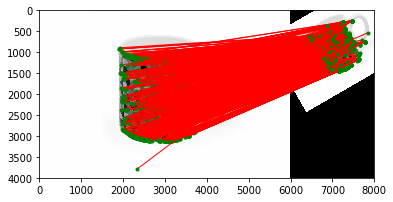

In [6]:
#describes correspondences between the original image and the rotated images
matches = briefMatch(descriptors[0], descriptors[1])
plotMatches(demo_img, test_demo_img, matches, ip[0], ip[1])

<a name="q2"></a>
## Compute Homography [ 25 pts]

To compute the homography, we need to implement the following function: 
`H2to1 = compute_homography (x_1, x_2)`

In that function, the inputs $x_1$ and $x_2$ are 2xN matrices of corresponding $(x, y)^T$ coordinates between two images, and output $H2to1$ is a 3x3 matrix encoding the homography that best matches the linear equation $Ah=0$, where <center>$A = \begin{bmatrix}
-u_1 & -v_1 & 1 & 0 & 0 & 0 & u_1x_1 & v_1x_1 & x_1  \\
0 & 0 & 0 & -u_2 & -v_2 & -1 & u_1y_1 & v_1y_1 & y_1 \\
\end{bmatrix}$</center>
<center></center>
<center>$h = \begin{bmatrix}
h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h{31} & h{32} & h_{33}  \\
\end{bmatrix}^T$</center>
<center></center>

The following hints may be helpful:
* A homography is only determined up to scale, meaning that you need to normalize the matrix by the element at the last row, last column. 
* The `numpy.linalg` function `eigh()` or `svd()` will be useful for solving the linear equation. 
* This function can be written without an explicit for-loop over the data points. There are 18 entries of matrix $A$, you can directly assign their value.


In [21]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
def compute_homography(p1, p2):
    """
    Compute homography 
    
    :param p1, p2: 2xN matrices of corresponding (x, y)^Transpose  
                 coordinates between two images
    :return H2to1: 3 x 3 matrix encoding the homography that best matches the linear 
            equation.
    """
    assert p1.shape[1] == p2.shape[1]
    assert p1.shape[0] == 2
    
    #############################
    # A_i:
    #  -x  -y  -1   0   0   0  xx'  yx'  x'
    #   0   0   0  -x  -y  -1  xy'  yy'  y'
    #############################
    
    A = np.zeros((2*p1.shape[1], 9)) #2N*9

    # set up each entry, no need for for-loop    
    # to be implemented - modify each entry of matrix A so that it match with the derived A epxression 
    A[1::2, 0] = p1[0, ...] 
    A[1::2, 1] = p1[1, ...] 
    A[1::2, 2] = 1 
    A[0::2, 3] = (p1[0, ...])*(-1)
    A[0::2, 4] = (p1[1, ...])*(-1)
    A[0::2, 5] = -1


    A[0::2, 6] = p1[0, ...]*p2[1, ...]
    A[1::2, 6] = p1[0, ...]*p2[0,:]*(-1)
    A[0::2, 7] = p1[1, ...]*p2[1, ...]
    A[1::2, 7] = p1[1, ...]*p2[0, ...]*(-1)
    A[0::2, 8] = p2[1, ...]
    A[1::2, 8] = p2[0, ...]*(-1)
    _, _, vh = np.linalg.svd(A)
    H2to1 = np.reshape(vh[8, ...], (3, 3))
    H2to1 = H2to1 / H2to1[2][2]    
    return  H2to1

# YOUR CODE HERE
# raise NotImplementedError()

<a name="q2"></a>
## RANSAC [ 25 pts]
Computation of homographies with a least-squares approach is not ideal due to the method's susceptibility to the influence of outliers when not all correspondences are good matches. Remember that homography estimations are sensitive to even a single poor correspondence and, when automatic detection of keypoints is performed, the likelihood of having a poor correspondence in your set of keypoints is high. To mitigate this effect of outliers, you'll need a plan. Using the Random Sample Consensus (RANSAC) approach is one way to reduce the effect of outliers on your results and improve your model. 

Therefore, you'll now need to implement RANSAC to automatically generate homographies between two images.

The following function will identify the homography with the highest number of inliers from the RANSAC process:

`bestH = ransac_homography(matches, locs1, locs2, num_iters, threshold)`

where: 
* the inputs `locs1` and `locs2` are matrices specifying point locations in each of the images
* `matches` is a matrix specifying matches between these two sets of point locations, which is the output from function `briefMatch`
* `num_iters` and `threshold` are hyperparameters for RANSAC algorithm:
    - `num_iters` determines how many loops are ran for RANSAC 
    - `threshold` determines the value for considering a point to be an inlier


In [ ]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
def ransac_homography(matches, locs1, locs2, num_iter=5000, threshold=2):
    """
    Returns the best homography by computing the best set of matches using
    RANSAC
    
    :param locs1, locs2: matrices specifying point locations in each of the images, 
                for locs1, should array with shape (N1, 2), where N1 is the number 
                of key-points detected in img1, 3 means the (x, y) location.
                Similar to locs2.
    :param matches: matrix specifying matches between these two sets of point locations. 
               These matrices are formatted identically to the output of the provided 
               briefMatch function.   
    :param num_iter: number of iterations to run RANSAC
    :param threshold: threshold value for considering a point to be an inlier

    :return bestH: homography matrix with the most inliers found during RANSAC
    """
    #################################################################
    # convert between OpenCV keypoint and match object to NumPy array
    #################################################################
    pts1, pts2 = [], []
    for match in matches:
        p1 = locs1[match[0]].pt
        p2 = locs2[match[1]].pt
        pts1.append(p1)
        pts2.append(p2)
    locs1 = np.array(pts1)
    locs2 = np.array(pts2)
    
    x1, x2 = np.vstack((locs1.T, np.ones(locs1.shape[0]))), np.vstack((locs2.T, np.ones(locs2.shape[0])))
    
    bestH = np.zeros((3, 3)) # to be implemented, should be an empty 3x3 NumPy array
    
    # RANSAC parameters
    max_inliers = -1
    max_selected_points = None
    # start RANSAC loop
    for _ in range(num_iter):
        picked_idx = np.random.choice(locs1.shape[0], 4)
        pts1, pts2 = locs1[picked_idx, ...].T, locs2[picked_idx, ...].T
        
        H = compute_homography(pts2, pts1)
        x1_pred = H @ x2
        x1_pred /= x1_pred[2:3, ...]
        error = np.sqrt(np.sum((x1_pred - x1)**2, axis=0))
        selected_points = np.argwhere(error <= threshold)
        num_inliers = selected_points.size  
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            max_selected_points = selected_points
            bestH = H
    H = bestH
    max_selected_points = max_selected_points.T.squeeze()
    pts1 = locs1[max_selected_points].T
    pts2 = locs2[max_selected_points].T
    bestH = compute_homography(pts2, pts1)
    return bestH


# YOUR CODE HERE
raise NotImplementedError()

<a name="q4"></a>
##  Automated Homography Estimation and Warping[ 25 pts]
You now have all the tools needed to compute the homography between two images. Starting from applying BRIEF feature descriptor to match the interest points between two images, you can then use these matches to compute the homography between two images and go through RANSAC to improve the robustness of the algorithm. 

To summarize, you can now do the following to achieve automated homography estimation and warping for two images:

1. Detect interest points (*e.g.* FAST, SIFT, etc.). You may call the corresponding function `briefLite`.
2. Match interest points between two images (*e.g.* BRIEF feature descriptor). You may call the corresponding function `briefMatch`.
3. Identify the best homography by *iteratively* applying RANSAC. You may call the corresponding function `ransac_homography`.

Now you will follow this pipeline for a simple application: change a book cover! 

In [ ]:
# load the image of the book
book = cv2.imread("img/book.jpg") #img folder

#load the image of the book cover
book_cover = cv2.imread("img/cover.jpg")

# load the image of the replacement book cover 
new_cover = cv2.imread("img/cover_new.jpg")

#resize the replacement to match the original book cover
new_cover = cv2.resize(new_cover, (book_cover.shape[1], book_cover.shape[0]))

In [ ]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
locs, decs = briefLite(book, book_cover)
matches = briefMatch(decs[0], decs[1])
bestH = ransac_homography(matches, locs[0], locs[1], num_iter=5000)
plotMatches(book,  book_cover, matches, locs[0], locs[1])

# YOUR CODE HERE
# raise NotImplementedError()

In [ ]:
def compositeH(H, template, img):
    """
    Returns final warped image. 
    
    :param H: homography 
    :param template: original image
    :param img: new cover image
    :return final_img: book with new cover
    """
    template_warped = cv2.warpPerspective(template, H, (img.shape[1], img.shape[0])) # change perspective
    template_blank_warped = cv2.warpPerspective(255 * np.ones(template.shape[:2], dtype=np.uint8), H, (img.shape[1],img.shape[0])) # create the region to apply
    img_masked = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(template_blank_warped)) # pixel-wise and
    return cv2.bitwise_or(img_masked, template_warped) # pixel-wise or

final_img = compositeH(bestH, new_cover, book)
plt.imshow(final_img[:,:,::-1]);

<a name="part-2"></a>
# Part 2: Panorama Stiching [ 25 pts]

In Part 2, you will use planar homography to generate a stitched panoramic image using multiple views of a scene. The images will differ by camera rotation only, not camera translation. 

You will generate a panorama two ways: 
* matched point correspondences (BRIEF, see Part 1)
* perspective warping (from the OpenCV library)

The OpenCV perspective warping function `warp_im = cv2.warpPerspective(im, H, out_size)` uses the homography `H` to warp the image `im` to `(out_size[0] - 1, out_size[1] - 1)`. The source image pixels are assumed to be from (0,0) to `(im.shape[1] - 1, im.shape[0] - 1)`. 


<a name="q4"></a>
## Image Stiching[ 15 pts]
You will now implement a function that takes two input images and an estimated homography to produce a panoramic image of the two input images. Instead of clipping, the input images are warped into a common third reference frame in which they can both be displayed without clipping. To do this, you must identify a matrix $M$ that performs only scaling and translation and obeys the following: 

* `warp_im1 = cv2.warpPerspective(im1, M, out_size)`
* `warp_im2 = cv2.warpPerspective(im2, M @ H2to1, out_size)`

The result should be warped, complete images inside a new reference frame. This can be accomplished by using either the height or width of `out_size` and then computing the other one based on a given image. Here, assume you take only `out_size[0]` representing the image width and compute `out_size[1]` representing the image height. The computation will be done in terms of $H2to1$ and the extreme points (corners) of the two images. Be sure that the matrix $M$ includes only scale and translation. You can find the aspect ratio of the full-sized panoroma image to help with this. 

In [ ]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
def imageStitching(im1, im2, H2to1):
    '''
    Returns a panorama of im1 and im2 using the given 
    homography matrix without cliping.

    :param im1, im2: input images which will be stiched to a panorama
    :param H2to1: a 3 x 3 matrix encoding the homography that best matches the linear equation
    :return panorama image that blends img1 and warped img2
    ''' 
    scale = 1
    tx = 0
    M_scale = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]], dtype=np.float64)

    im2_h, im2_w = im2.shape[0], im2.shape[1]

    corners = np.array([[0, 0], [0, im2_h], [im2_w, 0], [im2_w, im2_h]]).T
    wrapped_corner = (M_scale @ H2to1) @ np.concatenate([corners, np.ones((1, corners.shape[1]))])

    wrapped_corner /= np.reshape(wrapped_corner[2, ...], (1, wrapped_corner.shape[1]))
    wrapped_corner = wrapped_corner[0:2, ...]

    minh = np.min(wrapped_corner[1, ...])
    maxh = np.max(wrapped_corner[1, ...])
    maxw = np.max(wrapped_corner[0, ...])
    
    ty = max(0, -minh)
    M_translate = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]], dtype=np.float64) 
    out_width = int(math.ceil(maxw - 0))
    out_height = int(math.ceil(maxh - minh))
    out_size = (out_width, out_height)

    M = M_scale @ M_translate
    
    pano_im1 = cv2.warpPerspective(im1, M, out_size) / 255.
    pano_im2 = cv2.warpPerspective(im2, M_translate @ H2to1, out_size) / 255.
    

    im1_pano_mask = (pano_im1 > 0)
    im2_pano_mask = (pano_im2 > 0)

    im_center_mask = im1_pano_mask * im2_pano_mask 
    pano_im_full = pano_im1 + pano_im2

    im_R = pano_im_full * np.logical_not(im1_pano_mask)
    im_L = pano_im_full * np.logical_not(im2_pano_mask)

    im_center = pano_im_full * im_center_mask * 0.5
    pano_im = (im_center + im_R + im_L)
    return pano_im
# YOUR CODE HERE
# raise NotImplementedError()


<a name="q6"></a>
## Generate Panoramas [ 10 pts]

You will now auto-generate panoramic images from two input images with OpenCV by:
* computing interest points and descriptors. You may call function `briefLite`.
* identifying correspondences by matching interest point descriptors. You may call function `briefMatch`.
* using RANSAC to estimate a homography. You may call function `ransac_homography`.
* warping one image to align with the other. You may call function `imageStitching`.

This process is relatively computationally intensive and may require some time to run, depending on your environment.


In [ ]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
# load image
im1 = cv2.imread("img/l.png")
im2 = cv2.imread("img/r.jpg")

im1 = cv2.resize(im1, (w // 2, h // 2))
im2 = cv2.resize(im2, (w // 2, h // 2))

locs, decs = briefLite(im1, im2)  #to be implemented
matches = briefMatch(decs[0], decs[1])

# you might wnat to change number of iteration for RANSAC if estimated homography is bad. 
# it will be a good idea to start with setting num_iter=50000 and threshold=2
H2to1 = ransac_homography(matches, locs[0], locs[1], num_iter=500000, threshold=2)
pano_im = imageStitching(im1, im2, H2to1)

#plt.imshow(pano_im[:,:,::-1])

# YOUR CODE HERE
# raise NotImplementedError()

## Conclusion

Now that you've completed the assignment, think about each essential components for panaroma stiching. How can we compute the feature correspondance between 2 images? How can we estimate the planar homography between 2 images and make the computation robust enough to deal with the outlier? Finally, think about what might be the potential application of planar homography!


# Challenge Question

<a name="q10"></a>
## Try the algorithm with your own images! 
1. Take some pictures you want to stitch together to make a panoroma. We recommend you use a sturdy tripod to ensure that the camera only has rotation and no translation. Perhaps you figure out some other ways to make a camera rotate and not translate! 
2. For the simple application of changing the book cover, try to rotate the orientation of the book placed on the desk (*e.g.* rotate the `book.jpg` image by 90 degrees) and run `briefLite` and `briefMatch` to see what happen. Does the matching still perform as well as when the orientation of book.jpg and cover.jpg are aligned? Do you think BRIEF is rotation-invariant? If it is not, can you think about a way to improve BRIEF?